## WaveNet training

Here we train WaveNet to classify the MIT-BIH dataset, using hyperparameters drawn from `wavenet_hyperopt`.

In [1]:
import datetime
import os
import logging
import numpy as np
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

import tools.train as train
import tools.models as models
import tools.plot as plot

# Suppress tensorflow warnings about internal deprecations
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# Tensorboard logging
rightnow = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
nofftpath = os.path.join("..", "logs", rightnow, "nofft")

## Count data
files = ("../data/mitbih_train.csv", "../data/mitbih_test.csv")
inputs, labels, sparse_labels, df = train.preprocess(*files, fft=False)
# Add a dimension for "channels"
for key in inputs:
    inputs[key] = tf.expand_dims(inputs[key], axis=2)
train.class_count(df)

Using TensorFlow backend.



Train set
Count of each class
Classes
0.0    72471
1.0     2223
2.0     5788
3.0      641
4.0     6431
dtype: int64

Test set
Count of each class
Classes
0.0    18118
1.0      556
2.0     1448
3.0      162
4.0     1608
dtype: int64


In [2]:
largest_class_count = df["train"].groupby("Classes").size().max()
class_weights = np.divide(largest_class_count, df["train"].groupby("Classes").size().to_numpy())

print("Weighting the classes:", class_weights)


# Hyperparameters
nblocks = 12
nfilters = 94
batch_size = 500
l1_reg = 0.00020208366862898815
l2_reg = 0.0268783897138795

dilation_limit = inputs["train"].shape[1]

# Start
layerlist_res = [("conv", {"filters": nfilters, "width": 1, "padding": "causal"})]

# Residual blocks
models.add_res_blocks(nblocks, nfilters, dilation_limit, layerlist_res)

# End
layerlist_res.extend([
    (layers.Activation("relu"),),
    ("conv", {"filters": nfilters, "width": 1, "padding": "causal"}),
    ("conv", {"filters": nfilters, "width": 1, "padding": "causal", "activation": "linear"}),
])

config = {
    "optimizer": "Nadam",
    "loss": "sparse_categorical_crossentropy",
    "class_weights": class_weights,
    "batch_size": batch_size,
    "val_split": 0.05,
    "epochs": 300,
    "verbose": 0,
    "patience": 50,
    "metrics": ["accuracy"],
    "regularizer": regularizers.l1_l2(l1=l1_reg, l2=l2_reg),
    "logdir": nofftpath,
}

inputsize = inputs["train"].shape[1]
ncategories = labels["train"].shape[1]
model_res = models.create_conv1d(inputsize, layerlist_res, ncategories, config)
history = train.train_print(model_res, inputs, sparse_labels, config)

Weighting the classes: [  1.          32.60053981  12.52090532 113.05928237  11.26900949]
Model: "conv1d"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 187, 1)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 187, 94)      188         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 187, 94)      17766       conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 187, 94)      17766       conv1d[0][0]                     
___

add_16 (Add)                    (None, 187, 94)      0           add_15[0][0]                     
                                                                 conv1d_24[0][0]                  
__________________________________________________________________________________________________
add_17 (Add)                    (None, 187, 94)      0           add_16[0][0]                     
                                                                 conv1d_21[0][0]                  
__________________________________________________________________________________________________
add_18 (Add)                    (None, 187, 94)      0           add_17[0][0]                     
                                                                 conv1d_18[0][0]                  
__________________________________________________________________________________________________
add_19 (Add)                    (None, 187, 94)      0           add_18[0][0]                     
          

Let's see how the model did.

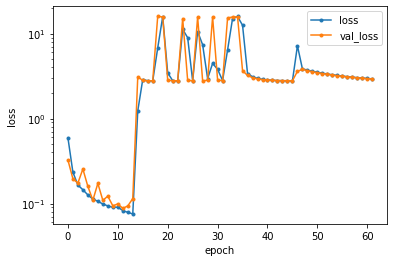

Confusion matrix, without normalization
[[18076    18     9     9     6]
 [  141   407     5     1     2]
 [   81     5  1329    25     8]
 [   32     0    10   120     0]
 [   27     0     2     0  1579]]


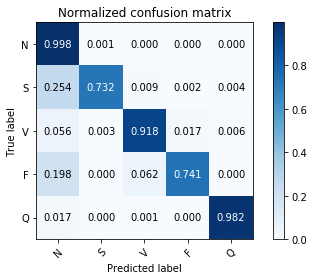

In [3]:
plot.plot_fit_history(history)

test_pred = np.argmax(model_res.predict(inputs["test"]), axis=1)
plot.plot_cm(
    sparse_labels["test"],
    test_pred,
    classes=np.array(["N", "S", "V", "F", "Q"]),
    normalize=True,
    norm_fmt=".3f",
)

Let's save the model with it's architecture and weights.

In [4]:
os.makedirs(os.path.join("..", "models", rightnow, "nofft"), exist_ok=True)
model_res.save(os.path.join("..", "models", rightnow, "nofft", "wavenet.h5"))